# ML Simulation Training
In this notebook you are going to train a ML policy.

However, you won't use examples from the SDV as data, but other agents around it instead.

This may sound like a small difference, but it has profound implications still:
- by using data from multiple sources you're **including much more variability in your training data**;
- two agents may have taken different choices at the same intersection, leading to **multi-modal data**;
- the **quality of the annotated data is expected to be sensibility lower** compared to the SDV, as we're leveraging a perception system.

Still, the final prize is even better than planning as this policy can potentially drive all the agents in the scene and it's not limited to the SDV only.

![simulation-example](https://github.com/lyft/l5kit/blob/master/docs/images/simulation/simulation_example.svg?raw=1)


In [1]:
from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset
from l5kit.rasterization import build_rasterizer
from l5kit.geometry import transform_points
from l5kit.visualization import TARGET_POINTS_COLOR, draw_trajectory
from l5kit.planning.rasterized.model import RasterizedPlanningModel

import os

## Prepare data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [2]:
#@title Download L5 Sample Dataset and install L5Kit
import os
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !wget https://raw.githubusercontent.com/lyft/l5kit/master/examples/setup_notebook_colab.sh -q
    !sh ./setup_notebook_colab.sh
    os.environ["L5KIT_DATA_FOLDER"] = open("./dataset_dir.txt", "r").read().strip()
else:
    print("Not running in Google Colab.")
    os.environ["L5KIT_DATA_FOLDER"] = "."

Not running in Google Colab.


In [3]:
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./config.yaml")

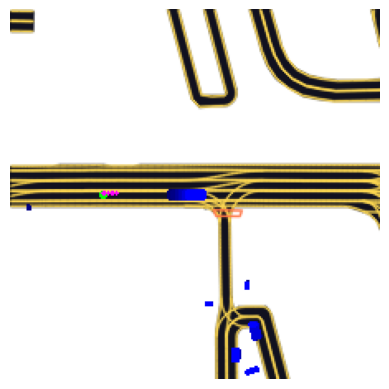

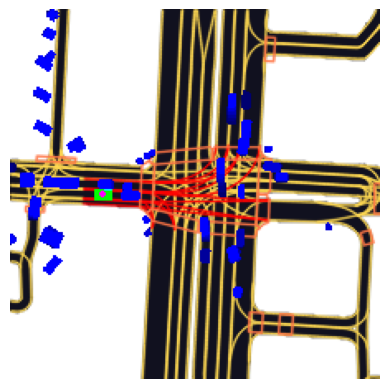

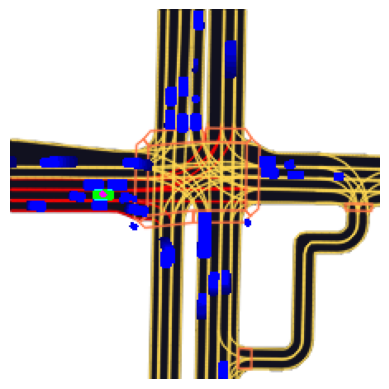

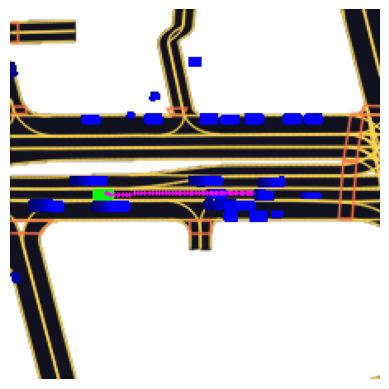

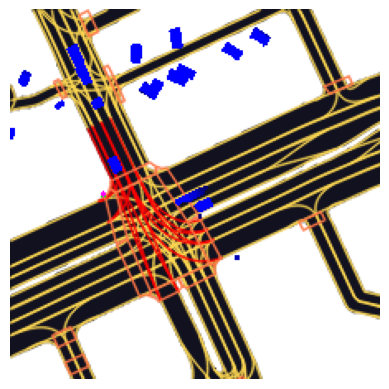

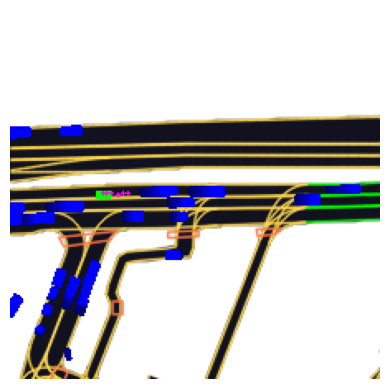

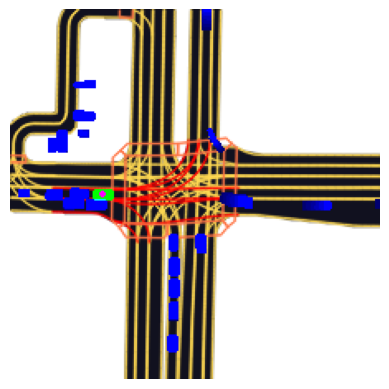

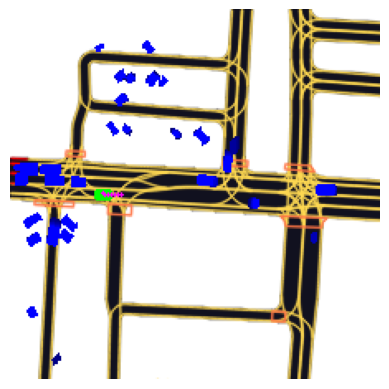

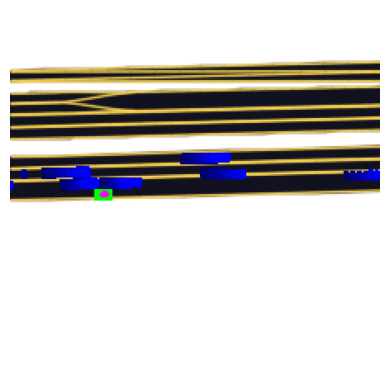

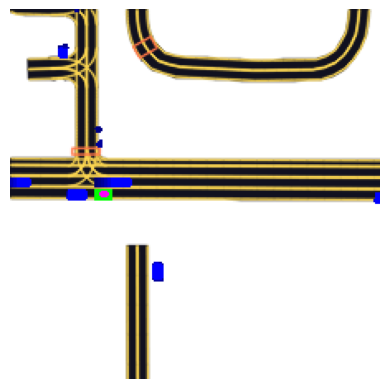

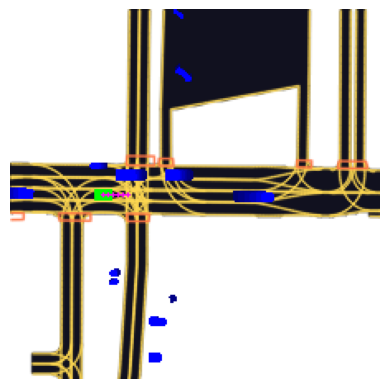

In [4]:
# rasterisation
rasterizer = build_rasterizer(cfg, dm)

# ===== INIT DATASET
train_zarr = ChunkedDataset(dm.require(cfg["train_data_loader"]["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)

# plot some examples
for idx in range(0, len(train_dataset), len(train_dataset) // 10):
    data = train_dataset[idx]
    im = rasterizer.to_rgb(data["image"].transpose(1, 2, 0))
    target_positions = transform_points(data["target_positions"], data["raster_from_agent"])
    draw_trajectory(im, target_positions, TARGET_POINTS_COLOR)
    plt.imshow(im)
    plt.axis('off')
    plt.show()
    
# 1, 2. AgentDataset, transform_points, draw_trajectory



In [5]:
model = RasterizedPlanningModel(
        model_arch=cfg["model_params"]["model_architecture"],
        num_input_channels=rasterizer.num_channels(),
        num_targets=3 * cfg["model_params"]["future_num_frames"],  # X, Y, Yaw * number of future states,
        weights_scaling= [1., 1., 1.],
        criterion=nn.MSELoss(reduction="none")
        )
print(model)

# 4. RasterizedPlanningModel, Loss

/home/jongwon/Desktop/l5kit/l5kit/l5kit/planning/rasterized/model.py:41: UserWarning: There is no pre-trained model with num_in_channels != 3, first layer will be reset
  warnings.warn("There is no pre-trained model with num_in_channels != 3, first layer will be reset")


RasterizedPlanningModel(
  (criterion): MSELoss()
  (model): ResNet(
    (conv1): Conv2d(15, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
    

# Prepare for training
Our `AgentDataset` inherits from PyTorch `Dataset`; so we can use it inside a `Dataloader` to enable multi-processing.

In [11]:
train_cfg = cfg["train_data_loader"]
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(train_dataset)

# 5. DataLoader

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


# Training loop
Here, we purposely include a barebone training loop. Clearly, many more components can be added to enrich logging and improve performance, such as:
- learning rate drop;
- loss weights tuning;
- importance sampling

To name a few.


Still, the sheer size of our dataset ensures that a reasonable performance can be obtained even with this simple loop.

In [12]:
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train = []
model.train()
torch.set_grad_enabled(True)

for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    # Forward pass
    
    data = {k: v.to(device) for k, v in data.items()}
    
    result = model(data)
    loss = result["loss"]
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")
    
    if _ % 10000 == 0:
        to_save = torch.jit.script(model.cpu())
        path_to_save = "models/simulation_model_"+str(_/10000)+".pt"
        to_save.save(path_to_save)
    
#6. Training 


loss: 85.1421127319336 loss(avg): 85.1421127319336:   0%|          | 1/100000 [00:04<135:52:38,  4.89s/it]


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

### Plot the train loss curve
We can plot the train loss against the iterations (batch-wise) to check if our model has converged.

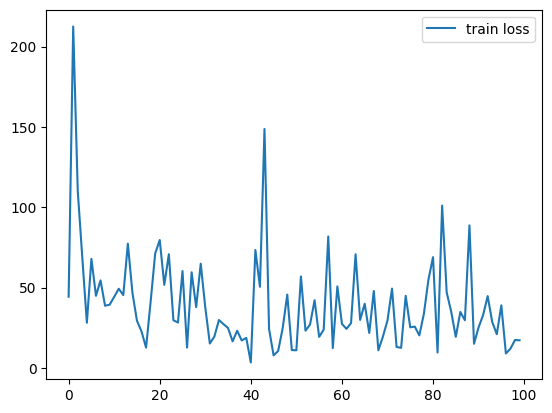

In [11]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.legend()
plt.show()

# Store the model

Let's store the model as a torchscript. This format allows us to re-load the model and weights without requiring the class definition later.

**Take note of the path, you will use it later to evaluate your planning model!**

In [12]:
to_save = torch.jit.script(model.cpu())
path_to_save = f"{gettempdir()}/simulation_model_.pt"
to_save.save(path_to_save)
print(f"MODEL STORED at {path_to_save}")

MODEL STORED at /tmp/simulation_model_.pt


# Congratulations in training your first ML policy for simulation!
### What's Next

Now that your model is trained and safely stored, you can use it to control the agents around ego. We have a notebook just for that.

### [Simulation evaluation](./simulation_test.ipynb)
In this notebook a `planning_model` will control the SDV, while the `simulation_model` you just trained will be used for all other agents.

Don't worry if you don't have the resources required to train a model, we provide pre-trained models just below.

## Pre-trained models
we provide a collection of pre-trained models for the simulation task:
- [simulation model](https://lyft-l5-datasets-public.s3-us-west-2.amazonaws.com/models/simulation_models/simulation_model_20210416_5steps.pt) trained on agents over the semantic rasteriser with history of 0.5s;
- [planning model](https://lyft-l5-datasets-public.s3-us-west-2.amazonaws.com/models/simulation_models/planning_model_20210421_5steps.pt) trained on the AV over the semantic rasteriser with history of 0.5s;

To use one of the models simply download the corresponding `.pt` file and load it in the evaluation notebooks.